<a href="https://colab.research.google.com/github/willhooi/gogosg/blob/main/IT5006_FD004_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsfresh --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series, impute
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_selection.selection import select_features

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Preparing the training data
train_data = pd.read_csv("/content/drive/MyDrive/CMAPSSData/train_FD004.txt", header=None, sep='\s+')
col_names = ["engine", "cycle", "setting1", "setting2", "setting3",
                 "sensor1", "sensor2", "sensor3", "sensor4", "sensor5",
                 "sensor6", "sensor7", "sensor8", "sensor9", "sensor10",
                 "sensor11", "sensor12", "sensor13", "sensor14", "sensor15",
                 "sensor16", "sensor17", "sensor18", "sensor19", "sensor20", "sensor21"]
train_data.columns = col_names
train_data.head()

,engine,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [ ]:
#reference: https://github.com/kpeters/exploring-nasas-turbofan-dataset/blob/master/8_FD004_LSTM.ipynb
# Calculate RUL
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="engine")
    max_cycle = grouped_by_unit["cycle"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train_data)

In [ ]:
# Prepare target and feature datasets
X_train_data = train_data
print(X_train_data.shape)

# Assuming piecewise linear degradation, early RUL is set as 125
y_train_data = train['RUL']
y_train_early_rul = y_train_data.clip(upper=125)
y_train_data = np.array(y_train_early_rul)
print(y_train_data.shape)

(61249, 26)
(61249,)


In [ ]:
# Preparing test data
test_data = pd.read_csv("/content/drive/MyDrive/CMAPSSData/test_FD004.txt", sep=" ", header=None)
test_data.drop(columns=[26, 27], inplace=True)
test_data.columns = col_names
X_test_data = test_data

y_true = pd.read_csv("/content/drive/MyDrive/CMAPSSData/RUL_FD004.txt", sep=" ", header=None)
y_true.drop(columns=[1], inplace=True)
y_true.columns = ['RUL']
y_true = y_true['RUL'].to_numpy()
y_true
print(y_true.shape)

(248,)


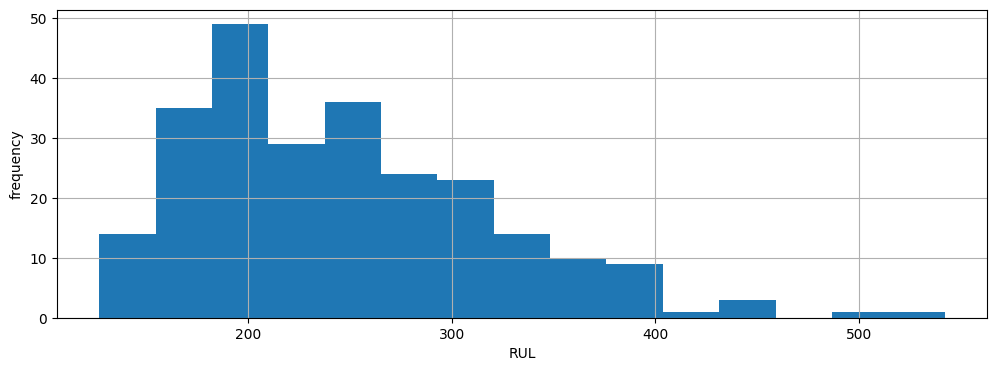

In [ ]:
# reference https://github.com/kpeters/exploring-nasas-turbofan-dataset
# Display distribution of RUL values
df_max_rul = train[['engine', 'RUL']].groupby('engine').first().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(12,4))
plt.xlabel("RUL")
plt.ylabel("frequency")
plt.show()

Observation: Mean RUL around 200. RUL doesnt not follow Gausian distribution and skewed towards to the right

In [ ]:
X_train_data.head()

,engine,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,8311.32,1.01,41.69,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,8713.60,1.07,43.94,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,8306.69,1.01,41.66,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,8312.35,1.02,41.68,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,7994.94,0.93,36.48,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [ ]:
X_test_data.head()

,engine,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,8704.98,1.07,43.83,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,7999.94,0.93,36.11,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,8305.38,1.01,41.52,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,5.69,137.23,2211.89,8301.00,1.01,41.73,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,7.97,192.94,2222.71,8331.05,1.02,41.32,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326


In [ ]:
# Perform EDA to identify active sensor for training data
print(X_train_data.columns)
print(X_train_data.shape)

Index(['engine', 'cycle', 'setting1', 'setting2', 'setting3', 'sensor1',
       'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7',
       'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13',
       'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19',
       'sensor20', 'sensor21'],
      dtype='object')
(61249, 26)


In [ ]:
X_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,61249.0,124.325181,71.995350,1.0000,60.0000,126.0000,185.0000,249.0000
cycle,61249.0,134.311417,89.783389,1.0000,62.0000,123.0000,191.0000,543.0000
setting1,61249.0,23.999823,14.780722,0.0000,10.0046,25.0014,41.9981,42.0080
setting2,61249.0,0.571347,0.310703,0.0000,0.2507,0.7000,0.8400,0.8420
setting3,61249.0,94.031576,14.251954,60.0000,100.0000,100.0000,100.0000,100.0000
sensor1,61249.0,472.882435,26.436832,445.0000,445.0000,462.5400,491.1900,518.6700
sensor2,61249.0,579.420056,37.342647,535.4800,549.3300,555.7400,607.0700,644.4200
sensor3,61249.0,1417.896600,106.167598,1242.6700,1350.5500,1367.6800,1497.4200,1613.0000
sensor4,61249.0,1201.915359,119.327591,1024.4200,1119.4900,1136.9200,1302.6200,1440.7700
sensor5,61249.0,8.031626,3.622872,3.9100,3.9100,7.0500,10.5200,14.6200


In [ ]:
# Identify sensors with low stanrdard deviation
std_dev = X_train_data.std()
low_std = std_dev[std_dev < 0.5].index
print(f"Columns with standard deviation less than 0.5:\n{low_std}")
col_to_drop = low_std.to_list()
col_to_drop

Columns with standard deviation less than 0.5:
Index(['setting2', 'sensor10', 'sensor16'], dtype='object')


['setting2', 'sensor10', 'sensor16']

In [ ]:
print(X_train_data.nunique(axis=0))

engine        249
cycle         543
setting1      536
setting2      105
setting3        2
sensor1         6
sensor2      1704
sensor3     13558
sensor4     17353
sensor5         6
sensor6        46
sensor7      5926
sensor8      1038
sensor9     25297
sensor10       21
sensor11      737
sensor12     5627
sensor13      483
sensor14    15938
sensor15    11915
sensor16        2
sensor17       54
sensor18        6
sensor19        2
sensor20      652
sensor21    21574
dtype: int64


Observation: settings3, sensor1,6,16,18,19 have few values. Likely to be discarded.

In [ ]:
# Drop sensors with nunique < 10
col_to_drop.extend(X_train_data.nunique()[X_train_data.nunique() < 10].index.tolist())
col_to_drop = list(set(col_to_drop))
print(col_to_drop)

['sensor18', 'setting3', 'sensor5', 'sensor10', 'sensor1', 'sensor16', 'setting2', 'sensor19']


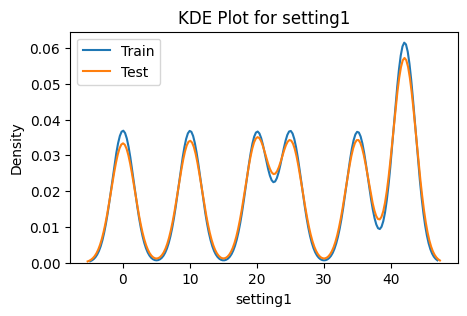

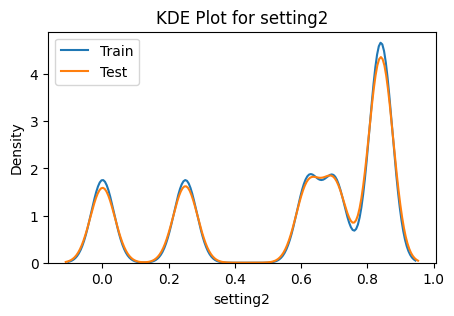

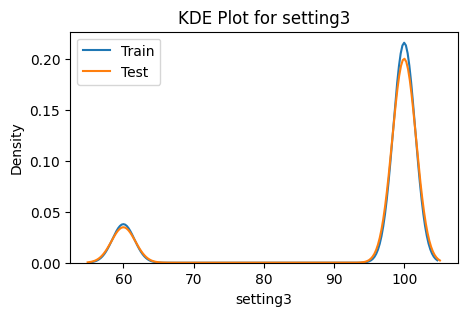

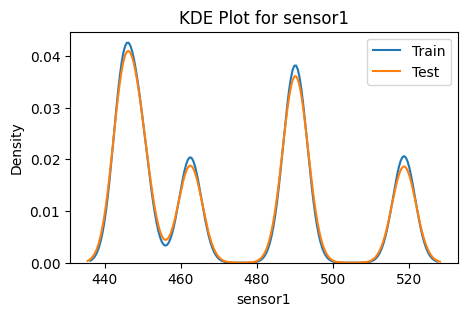

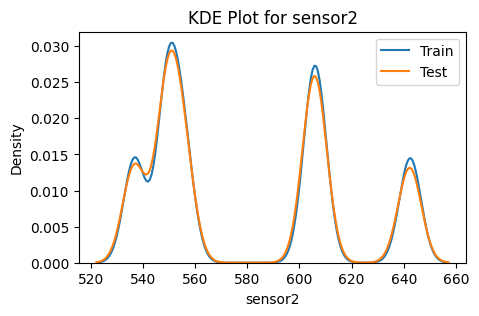

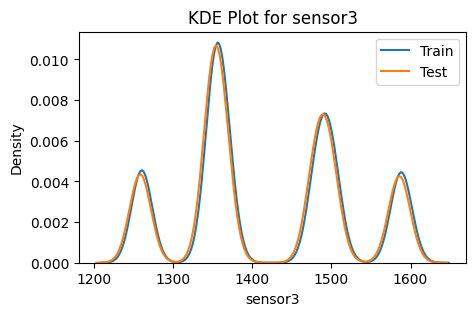

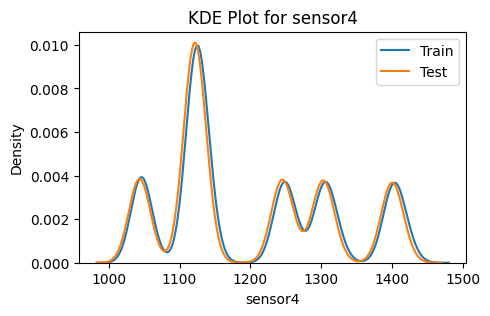

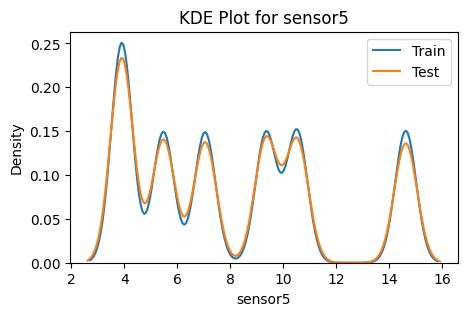

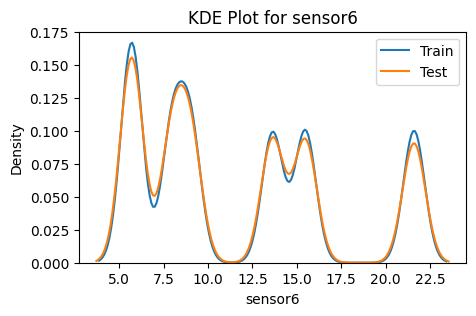

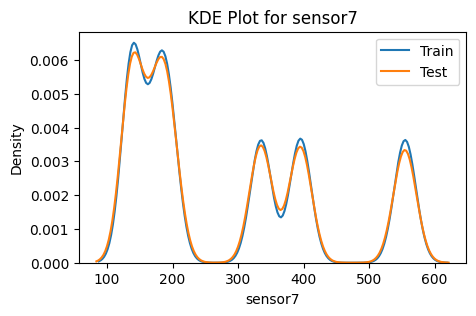

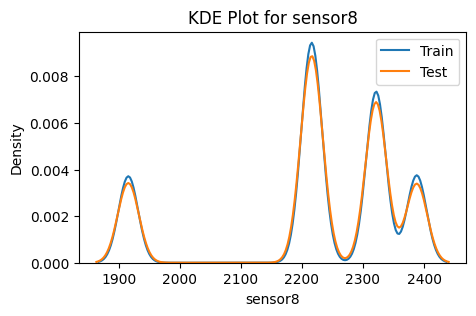

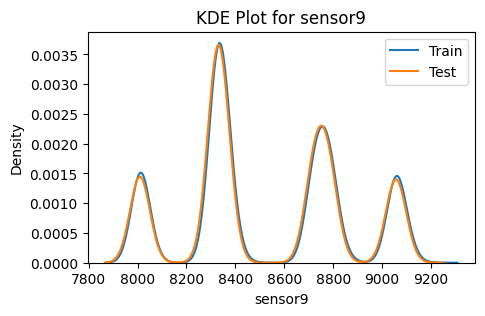

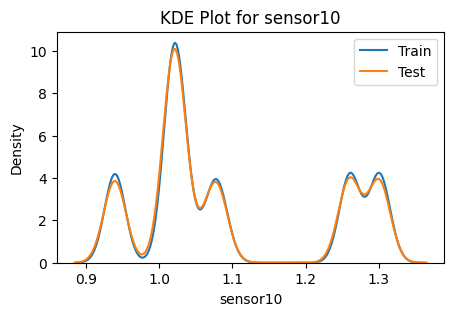

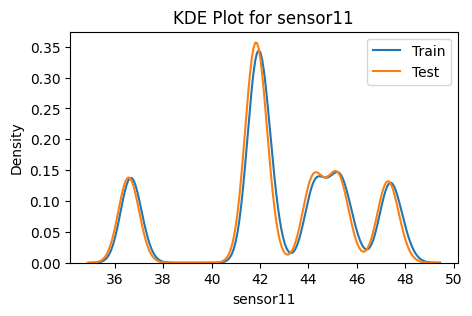

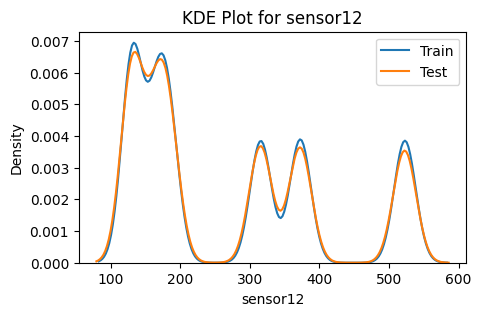

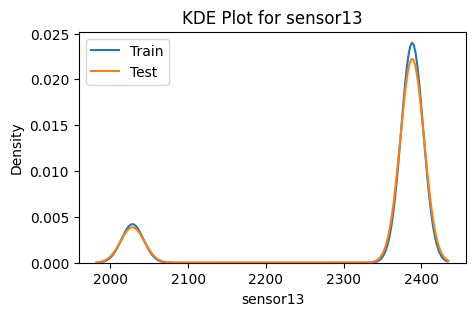

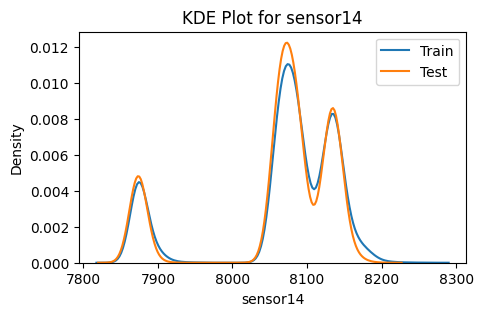

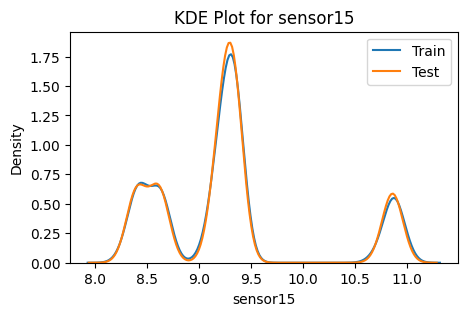

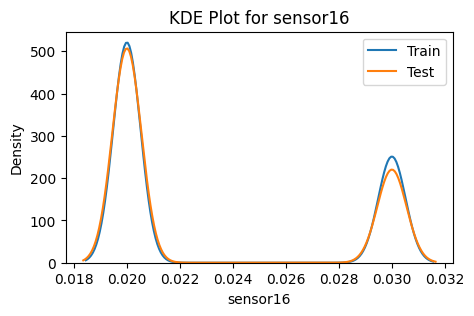

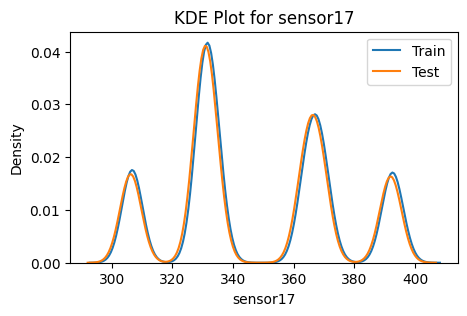

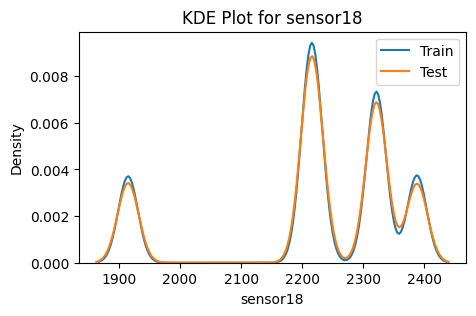

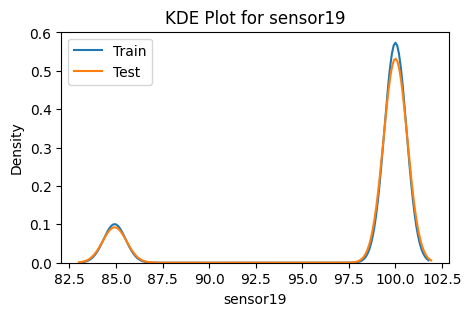

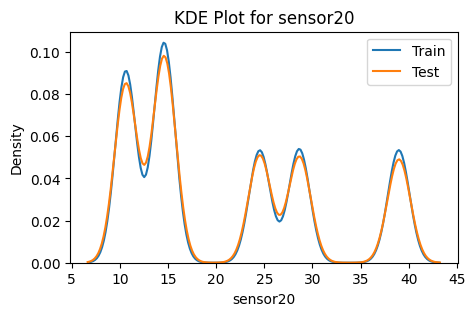

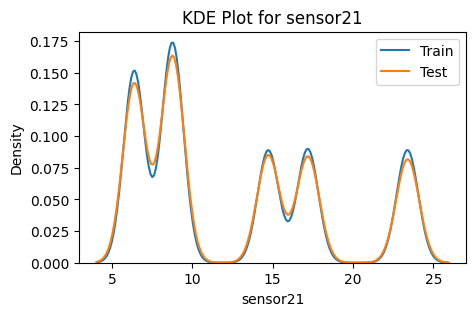

In [ ]:
# Generate KDE plot
for col in X_train_data.columns:
  if col not in ['engine','cycle','RUL']:
    plt.figure(figsize=(5,3))
    sns.kdeplot(X_train_data[col], label='Train')
    sns.kdeplot(X_test_data[col], label='Test')
    plt.title(f'KDE Plot for {col}')
    plt.legend()
    plt.show()

Observation: Distribution of both training & test data are very similar

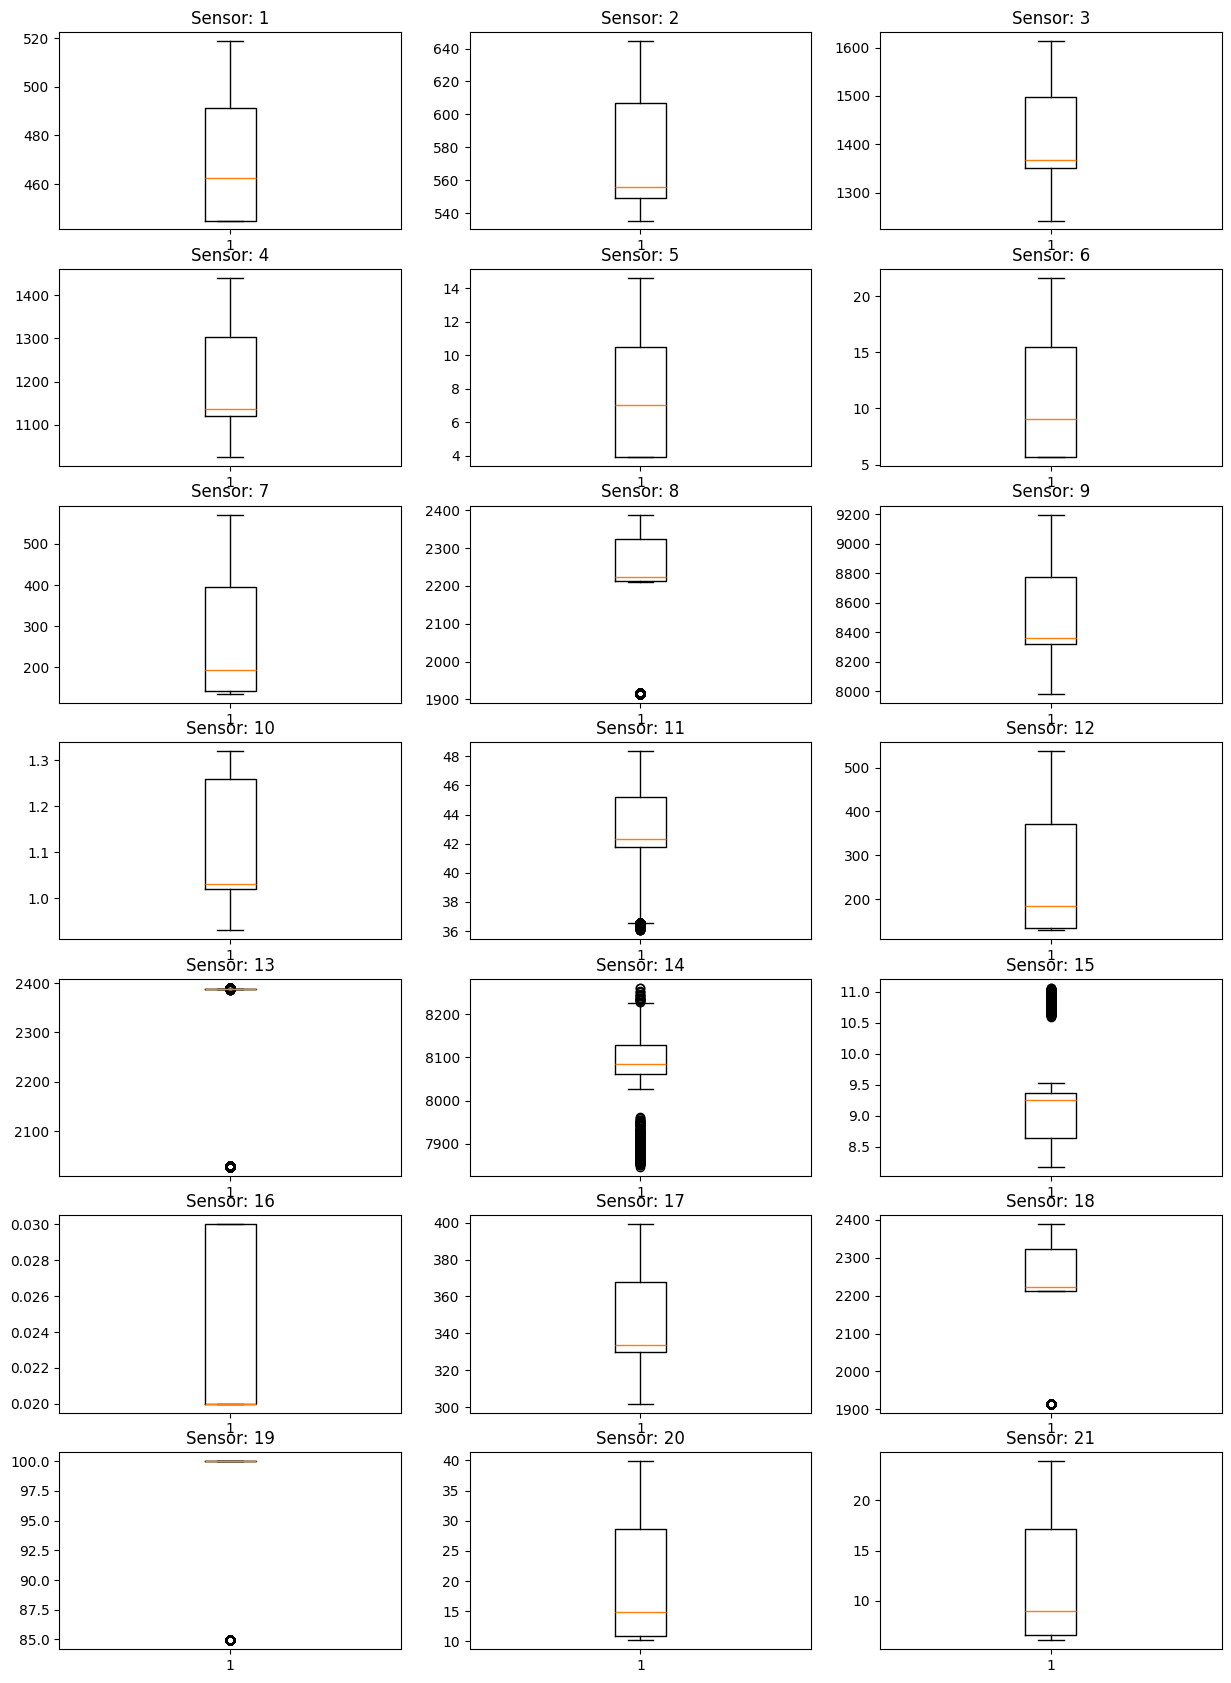

In [ ]:
# Display boxplot to determine distribution & identify outliers
plt.figure(figsize=(15, 21))
for i in np.arange(5, 26):
    temp = train_data.iloc[:, i]
    plt.subplot(7, 3, i-4)
    plt.boxplot(temp)
    plt.title("Sensor: " + str(i-4))
plt.show()

In [ ]:
# sensor 13,14 is problematic
col_to_drop.append('sensor13')
col_to_drop.append('sensor14')
print(col_to_drop)

['sensor18', 'setting3', 'sensor5', 'sensor10', 'sensor1', 'sensor16', 'setting2', 'sensor19', 'sensor13', 'sensor14']


Observation: Sensor 13 & 14 showed outliers tendency

In [ ]:
active_col = [col for col in col_names if col not in col_to_drop]
print(active_col)
active_sensors = active_col[2:] # drop engine, cycle
print(active_sensors)

['engine', 'cycle', 'setting1', 'sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor15', 'sensor17', 'sensor20', 'sensor21']
['setting1', 'sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


In [ ]:
# Drop columns
X_train_data.drop(columns=col_to_drop, inplace=True)
X_test_data.drop(columns=col_to_drop, inplace=True)

# Add dataset identifier for combining train and test sets
X_train_data['dataset'] = 'train'
X_test_data['dataset'] = 'test'

# Combine datasets with updated engine IDs for unique identifiers
max_unit = train_data['engine'].max()
X_test_data['engine'] += max_unit + 1
combined_data = pd.concat([X_train_data, X_test_data], ignore_index=True)
combined_data.head()

,engine,cycle,setting1,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor15,sensor17,sensor20,sensor21,dataset
0,1,1,42.0049,549.68,1343.43,1112.93,5.70,137.36,2211.86,8311.32,41.69,129.78,9.3335,330,10.62,6.3670,train
1,1,2,20.0020,606.07,1477.61,1237.50,13.61,332.10,2323.66,8713.60,43.94,312.59,9.1913,361,24.37,14.6552,train
2,1,3,42.0038,548.95,1343.12,1117.05,5.69,138.18,2211.92,8306.69,41.66,129.62,9.4007,329,10.48,6.4213,train
3,1,4,42.0000,548.70,1341.24,1118.03,5.70,137.98,2211.88,8312.35,41.68,129.80,9.3369,328,10.54,6.4176,train
4,1,5,25.0063,536.10,1255.23,1033.59,9.00,174.82,1915.22,7994.94,36.48,164.11,10.8366,305,14.03,8.6754,train


In [ ]:
# Generate rolling window features
def create_rolling_features(data, window_size=25, shift=5): #assuming gradual changes
    rolled_data = roll_time_series(data, column_id='engine', column_sort='cycle',
                                   max_timeshift=window_size - 1, rolling_direction=1)
    return rolled_data

rolled_data = create_rolling_features(combined_data)
rolled_data.head()

Rolling: 100%|██████████| 181/181 [00:16<00:00, 10.79it/s]


,engine,cycle,setting1,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor11,sensor12,sensor15,sensor17,sensor20,sensor21,dataset,id
0,1,1,42.0049,549.68,1343.43,1112.93,5.70,137.36,2211.86,8311.32,41.69,129.78,9.3335,330,10.62,6.3670,train,"(1, 1)"
497,1,1,42.0049,549.68,1343.43,1112.93,5.70,137.36,2211.86,8311.32,41.69,129.78,9.3335,330,10.62,6.3670,train,"(1, 2)"
498,1,2,20.0020,606.07,1477.61,1237.50,13.61,332.10,2323.66,8713.60,43.94,312.59,9.1913,361,24.37,14.6552,train,"(1, 2)"
1491,1,1,42.0049,549.68,1343.43,1112.93,5.70,137.36,2211.86,8311.32,41.69,129.78,9.3335,330,10.62,6.3670,train,"(1, 3)"
1492,1,2,20.0020,606.07,1477.61,1237.50,13.61,332.10,2323.66,8713.60,43.94,312.59,9.1913,361,24.37,14.6552,train,"(1, 3)"


In [ ]:
# Feature extraction targetting active sensors only

def extract_sensor_features(data, sensors):
    kind_to_fc_parameters = {feature: MinimalFCParameters() for feature in sensors}
    extracted_features = extract_features(
        rolled_data.drop(columns=["engine", "dataset"]),
        column_id="id", column_sort="cycle",
        kind_to_fc_parameters=kind_to_fc_parameters)
    return extracted_features

extracted_features = extract_sensor_features(rolled_data, active_sensors)
extracted_features.head()

Feature Extraction: 100%|██████████| 240/240 [05:50<00:00,  1.46s/it]


setting1__sum_values  setting1__median  ...  sensor21__absolute_maximum  sensor21__minimum
1 1               42.0049          42.00490  ...                      6.3670              6.367
  2               62.0069          31.00345  ...                     14.6552              6.367
  3              104.0107          42.00380  ...                     14.6552              6.367
  4              146.0107          42.00190  ...                     14.6552              6.367
  5              171.0170          42.00000  ...                     14.6552              6.367

[5 rows x 140 columns]

In [ ]:
dataset_labels = combined_data['dataset'].reset_index(drop=True)
dataset_labels.index = extracted_features.index

# Separate extracted features into train and test sets
train_features = extracted_features[dataset_labels == 'train']
true_features = extracted_features[dataset_labels == 'test']

In [ ]:
# Feature selection
selected_features = select_features(train_features, y_train_data)
X_test_selected = true_features[selected_features.columns]

In [ ]:
# Train/test split and normalization (apply log transformation on y_train_data)
y_train_log = np.log1p(y_train_data)
X_train, X_test, y_train, y_test = train_test_split(selected_features, y_train_log, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_selected_scaled_values = scaler.transform(X_test_selected)

In [ ]:
# Train Random Forest Regressor using train data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

In [ ]:
# Evaluate performance after inverse transformation
y_val_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)
mse = mean_squared_error(y_val_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_orig, y_pred_orig)

#mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 381.9692893540397
Root Mean Squared Error: 19.544034623230683
R-squared: 0.7714940755139398


Mean Squared Error: 1082.0451475174318
Root Mean Squared Error: 32.894454662107286
R-squared: 0.6360235727449162


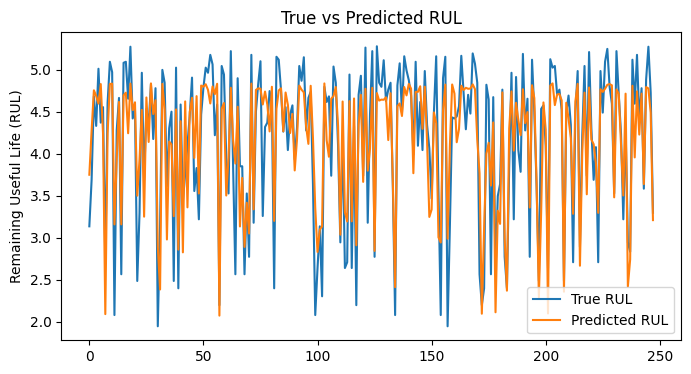

In [ ]:
# Process and evaluate on test set
def process_predictions(result_df, pred_column, y_test_rul):
    y_pred = [group[pred_column].tail(3).median() for _, group in result_df.groupby(level=0)]
    mse = mean_squared_error(np.expm1(y_test_rul), np.expm1(y_pred))
    rmse = np.sqrt(mse)
    r2 = r2_score(np.expm1(y_test_rul), np.expm1(y_pred))

    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', r2)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(y_test_rul, label='True RUL')
    plt.plot(y_pred, label='Predicted RUL')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(f'True vs Predicted RUL')
    plt.legend()
    plt.show()

    return y_pred

# Apply to Random Forest predictions
rf_result_df = pd.DataFrame(X_test_selected_scaled_values, index=X_test_selected.index, columns=X_test_selected.columns)
rf_result_df['y_pred_rf'] = rf.predict(X_test_selected_scaled_values)
y_pred_rf = process_predictions(rf_result_df, 'y_pred_rf', np.log1p(y_true))

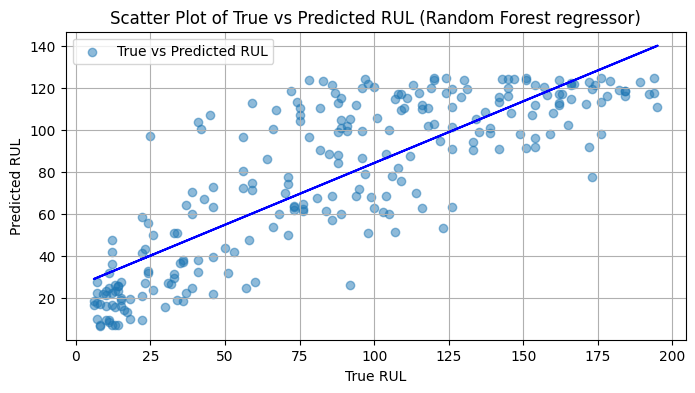

In [ ]:

# Plot with regression line
plt.figure(figsize=(8, 4))
plt.scatter(np.exp(np.log(y_true+1))-1, np.exp(y_pred_rf)-1, label='True vs Predicted RUL', alpha=0.5)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Scatter Plot of True vs Predicted RUL (Random Forest regressor)')

# Calculate regression line
m, b = np.polyfit(np.exp(np.log(y_true+1))-1, np.exp(y_pred_rf)-1, 1)
plt.plot(np.exp(np.log(y_true+1))-1, m * (np.exp(np.log(y_true+1))-1) + b, color='blue')


plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Training with XGBoost
!pip install xgboost --quiet

from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate performance after inverse transformation
y_val_orig = np.exp(y_test)-1
y_pred_orig = np.exp(y_pred_xgb)-1
mse = mean_squared_error(y_val_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_orig, y_pred_orig)

#mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00
Mean Squared Error: 377.7386965376805
Root Mean Squared Error: 19.435500933541192
R-squared: 0.7740249478892061


Mean Squared Error: 1044.8108117664265
Root Mean Squared Error: 32.32353340472583
R-squared: 0.648548392553924


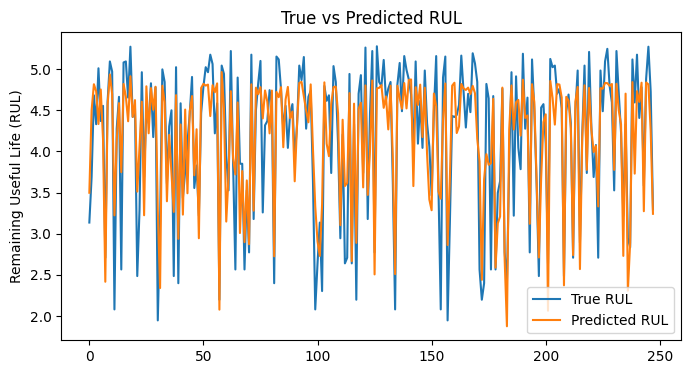

In [ ]:
# Process and evaluate on test set
def process_predictions(result_df, pred_column, y_test_rul):
    y_pred = [group[pred_column].tail(3).median() for _, group in result_df.groupby(level=0)]
    mse = mean_squared_error(np.exp(y_test_rul)-1, np.exp(y_pred)-1)
    rmse = np.sqrt(mse)
    r2 = r2_score(np.exp(y_test_rul)-1, np.exp(y_pred)-1)

    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', r2)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(y_test_rul, label='True RUL')
    plt.plot(y_pred, label='Predicted RUL')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(f'True vs Predicted RUL')
    plt.legend()
    plt.show()

    return y_pred

# Apply to Random Forest predictions
xgb_result_df = pd.DataFrame(X_test_selected_scaled_values, index=X_test_selected.index, columns=X_test_selected.columns)
xgb_result_df['y_pred_xgb'] = xgb.predict(X_test_selected_scaled_values)
y_pred_xgb = process_predictions(xgb_result_df, 'y_pred_xgb', np.log(y_true+1))

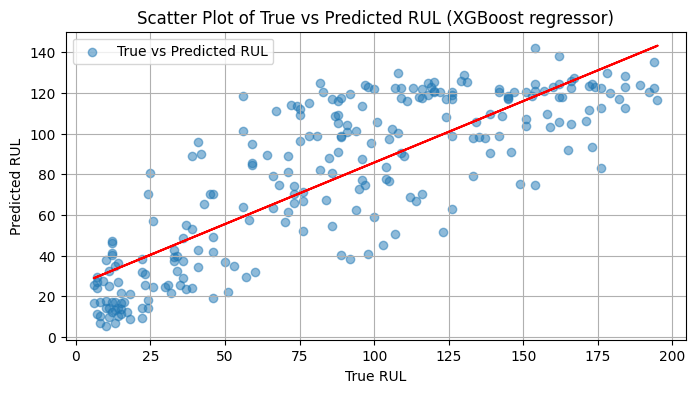

In [ ]:

# Plot with regression line for XGBoost
plt.figure(figsize=(8, 4))
plt.scatter(np.exp(np.log(y_true+1))-1, np.exp(y_pred_xgb)-1, label='True vs Predicted RUL', alpha=0.5)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Scatter Plot of True vs Predicted RUL (XGBoost regressor)')

# Calculate regression line
m, b = np.polyfit(np.exp(np.log(y_true+1))-1, np.exp(y_pred_xgb)-1, 1)
plt.plot(np.exp(np.log(y_true+1))-1, m * (np.exp(np.log(y_true+1))-1) + b, color='red') # Changed color to red

plt.legend()
plt.grid(True)
plt.show()